# **Aplicaciones Prácticas de Procesamiento de Imágenes**

## Marcos Carnerero Blanco 22M039 y Sergio Gil Atienza 22M047

**Objetivo:** Este cuaderno explora técnicas avanzadas y aplicaciones prácticas que se construyen sobre los fundamentos del procesamiento de imágenes. Al finalizar, el estudiante podrá mejorar imágenes de bajo contraste, cuantificar y analizar texturas, segmentar objetos de forma automática y localizar patrones dentro de una imagen.

**Librerías utilizadas:**
*   `NumPy`: Para operaciones numéricas eficientes.
*   `Matplotlib`: Para todas las visualizaciones.
*   `scikit-image`: Una potente librería con algoritmos de alto nivel para procesamiento de imágenes.
*   `OpenCV (cv2)`: Se utilizará para una implementación optimizada de Template Matching.


In [2]:
# --- Configuración Inicial ---
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, exposure, util, measure
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import threshold_otsu
from skimage.morphology import disk, square, closing
from skimage.io import imread
from skimage.color import rgb2gray
import cv2 # Se usará para Template Matching

### **1. Ecualización de Histograma para Mejora de Contraste**

**¿Por qué es útil?**
Muchas imágenes son capturadas en condiciones de iluminación no ideales (muy oscuras, muy claras o con niebla), lo que resulta en un bajo contraste. La ecualización del histograma es una técnica de operación de punto que redistribuye los niveles de intensidad de los píxeles para aprovechar todo el rango dinámico, mejorando drásticamente el contraste global.

**¿Cómo funciona?**
El objetivo es transformar el histograma de la imagen en uno lo más plano (uniforme) posible. Esto se logra mediante los siguientes pasos:
1.  **Calcular el histograma** de la imagen original.
2.  **Calcular el histograma acumulativo (CDF)**, que indica, para cada nivel de intensidad, cuántos píxeles tienen ese valor o uno inferior.
3.  **Normalizar la CDF** para que sus valores vayan de 0 a 255. Esta CDF normalizada actúa como una "tabla de mapeo".
4.  **Aplicar el mapeo:** El nuevo valor de cada píxel será el valor correspondiente en la CDF normalizada.


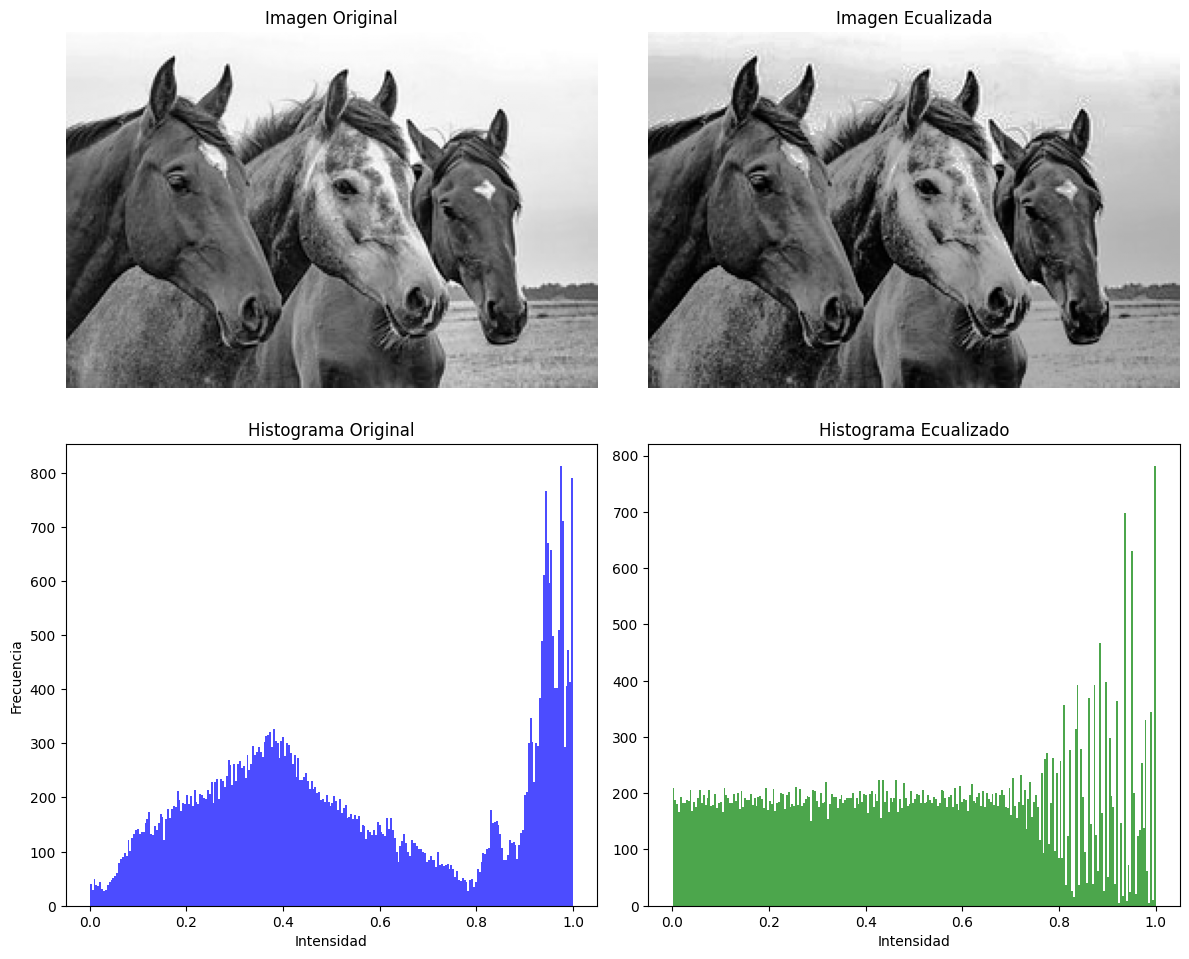

In [3]:
# Cargar una imagen de ejemplo de bajo contraste
# La imagen 'moon' de scikit-image es un buen ejemplo
image_rgb = imread('horses.jpg')
image_gray = rgb2gray(image_rgb)

# --- Ecualización usando la función de scikit-image ---
# Es la forma más rápida y recomendada en la práctica.
image_equalized_sk = exposure.equalize_hist(image_gray)

# --- Visualización Comparativa ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Imagen Original y su Histograma
axes[0, 0].set_title('Imagen Original')
axes[0, 0].imshow(image_gray, cmap='gray')
axes[0, 0].axis('off')

axes[1, 0].set_title('Histograma Original')
axes[1, 0].hist(image_gray.ravel(), bins=256, color='blue', alpha=0.7)
axes[1, 0].set_xlabel('Intensidad')
axes[1, 0].set_ylabel('Frecuencia')

# Imagen Ecualizada y su Histograma
axes[0, 1].set_title('Imagen Ecualizada')
axes[0, 1].imshow(image_equalized_sk, cmap='gray')
axes[0, 1].axis('off')

axes[1, 1].set_title('Histograma Ecualizado')
axes[1, 1].hist(image_equalized_sk.ravel(), bins=256, color='green', alpha=0.7)
axes[1, 1].set_xlabel('Intensidad')

plt.tight_layout()
plt.show()

**Observación:** Nota cómo el histograma original está concentrado en un rango estrecho de intensidades. Después de la ecualización, el histograma se "estira" para cubrir todo el rango posible, revelando detalles que antes no eran visibles.

### **2. Análisis de Textura con Características de Haralick**

**¿Por qué es útil?**
La textura es una propiedad fundamental de las superficies que nos permite distinguir, por ejemplo, entre madera, tela, hierba o arena. Las características de Haralick nos permiten **cuantificar la textura** de una imagen, convirtiendo esta propiedad visual en un conjunto de números. Esto es crucial en campos como la imagenología médica (para diferenciar tejidos sanos de enfermos) o el análisis de imágenes satelitales (para clasificar tipos de terreno).

**¿Cómo funciona?**
Se basan en la **Matriz de Co-ocurrencia de Niveles de Gris (GLCM)**. De forma intuitiva, la GLCM es una matriz que cuenta la frecuencia con la que un píxel con intensidad `i` aparece junto a un píxel con intensidad `j`, dada una cierta distancia y ángulo. A partir de esta matriz, Haralick definió varias métricas:

*   **Contraste:** Mide la varianza local. Texturas con patrones muy marcados y cambios bruscos tienen alto contraste.

  $\text{Contraste} = \sum_{i,j} P(i, j) \cdot (i - j)^2$

*   **Correlación:** Mide cuán predecible es un píxel a partir de su vecino. Texturas lineales y estructuradas tienen alta correlación.
  
  $\text{Correlación} = \frac{\sum_{i,j} P(i,j) \cdot (i - \mu_i) \cdot (j - \mu_j)}{\sigma_i \cdot \sigma_j}$

Donde: 
- $\mu_i$: Media de los niveles de intensidad en $i$.
- $\mu_j$: Media de los niveles de intensidad en $j$.
- $\sigma_i$: Desviación estándar de $i$.
- $\sigma_j$: Desviación estándar de $j$.

*   **Energía:** Mide la uniformidad. Una textura con pocos niveles de gris tendrá alta energía.

$\text{Energía} = \sum_{i,j} P(i, j)^2$

*   **Homogeneidad:** Mide la similitud local. Texturas suaves y sin cambios bruscos tienen alta homogeneidad.

$\text{Homogeneidad} = \sum_{i,j} \frac{P(i, j)}{1 + |i - j|}$


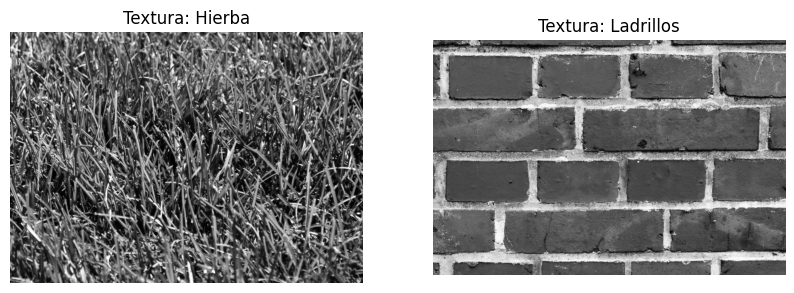

--- Características de Haralick para: Hierba ---
  Contraste:   1234.45
  Correlación: 0.80
  Energía:     0.01
  Homogeneidad:0.07

--- Características de Haralick para: Ladrillos ---
  Contraste:   482.60
  Correlación: 0.90
  Energía:     0.02
  Homogeneidad:0.11



In [4]:
# Cargar imágenes con texturas diferentes

img_grass = cv2.imread("grass.jpg")
image_grass_gray = cv2.cvtColor(img_grass, cv2.COLOR_BGR2GRAY)
img_brick = cv2.imread("bricks.jpg")
image_brick_gray = cv2.cvtColor(img_brick, cv2.COLOR_BGR2GRAY)

# Función para calcular y mostrar las características
def compute_and_print_haralick(image, name):
    # Calcular GLCM. Usaremos una distancia de 1 píxel en 4 direcciones (0, 45, 90, 135 grados)
    glcm = graycomatrix(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    
    # Calcular las características promediando sobre los ángulos
    contrast = np.mean(graycoprops(glcm, 'contrast'))
    correlation = np.mean(graycoprops(glcm, 'correlation'))
    energy = np.mean(graycoprops(glcm, 'energy'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))
    
    print(f"--- Características de Haralick para: {name} ---")
    print(f"  Contraste:   {contrast:.2f}")
    print(f"  Correlación: {correlation:.2f}")
    print(f"  Energía:     {energy:.2f}")
    print(f"  Homogeneidad:{homogeneity:.2f}\n")

# --- Visualización y Cálculo ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_grass_gray, cmap='gray')
axes[0].set_title('Textura: Hierba')
axes[0].axis('off')

axes[1].imshow(image_brick_gray, cmap='gray')
axes[1].set_title('Textura: Ladrillos')
axes[1].axis('off')
plt.show()

compute_and_print_haralick(image_grass_gray, "Hierba")
compute_and_print_haralick(image_brick_gray, "Ladrillos")

**Observación:** La textura de ladrillos es más estructurada y repetitiva, lo que se refleja en una mayor correlación y homogeneidad en comparación con la textura más caótica de la hierba.

### **3. Segmentación con Umbral de Otsu y Operaciones Morfológicas**

**¿Por qué es útil?**
La segmentación es el proceso de dividir una imagen en regiones significativas, típicamente para separar un **objeto de interés** de su **fondo**. El método de Otsu es una técnica de umbralización **automática**, lo que significa que no necesitamos elegir un umbral manualmente. Encuentra el valor óptimo que mejor separa los dos grupos de píxeles (objeto y fondo).

**¿Cómo funciona?**
Otsu prueba todos los umbrales posibles (de 0 a 255) y elige aquel que **maximiza la varianza entre las dos clases** (inter-class variance). Una vez que la imagen está binarizada, a menudo contiene "ruido" (píxeles aislados) o "agujeros" en los objetos. Las **operaciones morfológicas** se utilizan para limpiar este resultado:
*   **Cierre (Closing):** Rellena pequeños agujeros dentro de los objetos. Se compone de una dilatación seguida de una erosión.
*   **Apertura (Opening):** Elimina pequeños puntos de ruido fuera de los objetos. Se compone de una erosión seguida de una dilatación.


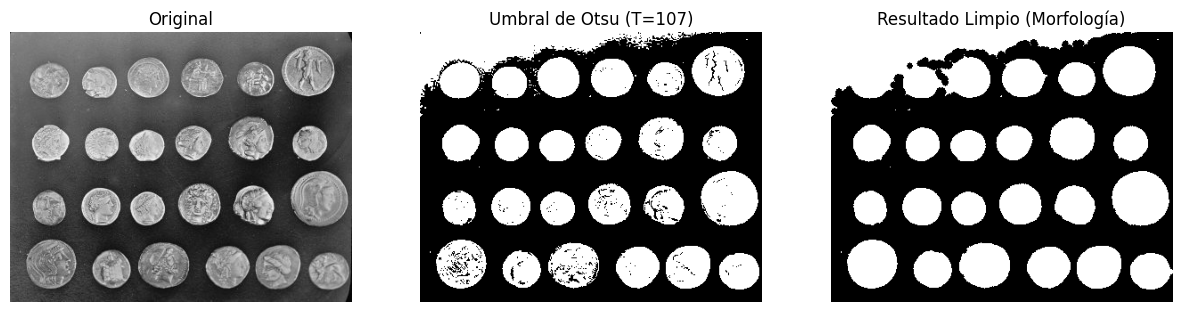

In [5]:
# Cargar una imagen para segmentar
from skimage.data import coins
image_to_segment = coins()

# --- Paso 1: Aplicar el método de Otsu ---
otsu_threshold = threshold_otsu(image_to_segment)
binary_image = image_to_segment > otsu_threshold

# --- Paso 2: Limpiar la imagen con operaciones morfológicas ---
# Usaremos 'closing' para rellenar los agujeros negros dentro de las monedas.
# El 'structuring element' (selem) define la forma de la operación.
selem = disk(3)
cleaned_image = closing(binary_image, selem)

# --- Visualización del Proceso ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].set_title('Original')
axes[0].imshow(image_to_segment, cmap='gray')
axes[0].axis('off')

axes[1].set_title(f'Umbral de Otsu (T={otsu_threshold})')
axes[1].imshow(binary_image, cmap='gray')
axes[1].axis('off')

axes[2].set_title('Resultado Limpio (Morfología)')
axes[2].imshow(cleaned_image, cmap='gray')
axes[2].axis('off')

plt.show()

### **4. Detección de Patrones con Template Matching**

**¿Por qué es útil?**
Permite encontrar una pequeña imagen (plantilla o *template*) dentro de una imagen más grande. Es la base de muchas aplicaciones, como el reconocimiento facial simple, el control de calidad en líneas de producción (para verificar la presencia de un logo) o la navegación de robots.

**¿Cómo funciona?**
La técnica desliza la plantilla sobre toda la imagen principal. En cada posición, calcula una métrica de similitud. La **Correlación Cruzada Normalizada (NCC)** es una de las métricas más robustas. Genera una "mapa de correlación" donde el punto más brillante indica la mejor coincidencia. Usaremos la implementación optimizada de OpenCV, que es mucho más rápida.


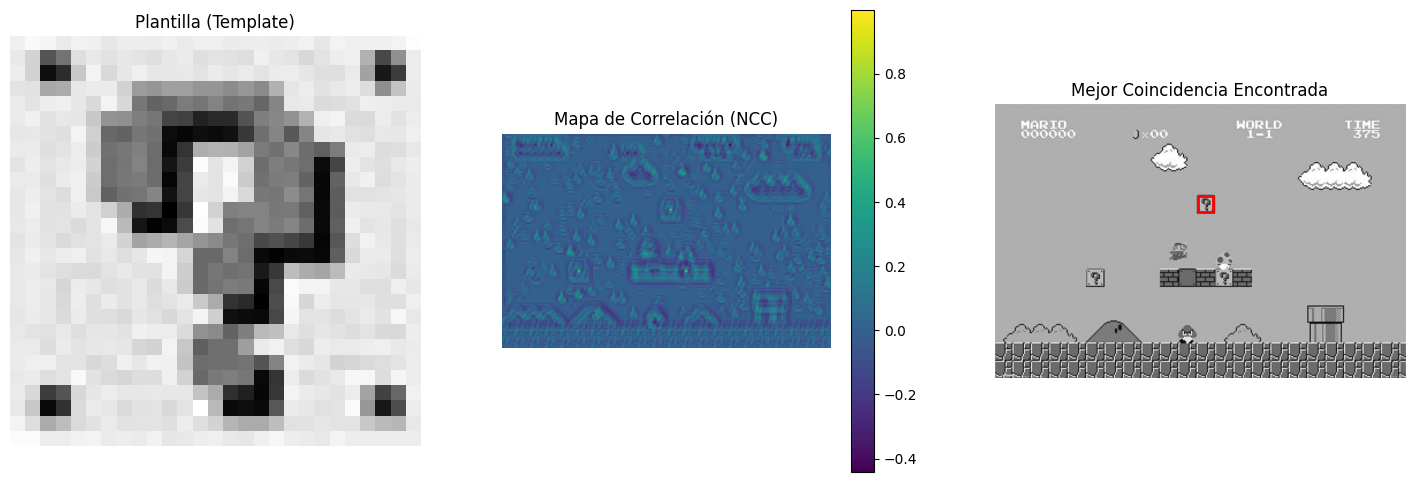

In [6]:
# Cargar imagen principal y plantilla
image_main = cv2.imread("super_mario.jpg")


template = cv2.imread("template.jpg")


# Asegurarse de que ambas imágenes estén en escala de grises y en formato uint8
image_main_gray = util.img_as_ubyte(cv2.cvtColor(image_main, cv2.COLOR_BGR2GRAY))
template_gray = util.img_as_ubyte(cv2.cvtColor(template, cv2.COLOR_BGR2GRAY))

# Realizar el template matching con OpenCV
# cv2.TM_CCOEFF_NORMED corresponde a la Correlación Cruzada Normalizada
result = cv2.matchTemplate(image_main_gray, template_gray, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# La ubicación del valor máximo es la esquina superior izquierda de la coincidencia
top_left = max_loc
h, w = template_gray.shape
bottom_right = (top_left[0] + w, top_left[1] + h)

# --- Visualización ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(template_gray, cmap='gray')
axes[0].set_title('Plantilla (Template)')
axes[0].axis('off')

# Mostrar el mapa de correlación
im = axes[1].imshow(result, cmap='viridis')
axes[1].set_title('Mapa de Correlación (NCC)')
axes[1].axis('off')
fig.colorbar(im, ax=axes[1])

# Dibujar el rectángulo en la imagen principal
axes[2].imshow(image_main_gray, cmap='gray')
axes[2].add_patch(plt.Rectangle(top_left, w, h, edgecolor='red', facecolor='none', linewidth=2))
axes[2].set_title('Mejor Coincidencia Encontrada')
axes[2].axis('off')

plt.show()

### **5. Ejercicios Propuestos**

**Ejercicio 1: Ecualización Adaptativa**
La ecualización de histograma global puede producir resultados poco naturales en algunas imágenes. 
1. Investiga y aplica la **Ecualización de Histograma Adaptativa (CLAHE)**, disponible en `skimage.exposure.equalize_adapthist`.
2. Compara el resultado de la ecualización global, CLAHE y la imagen original. ¿Qué diferencias notas?

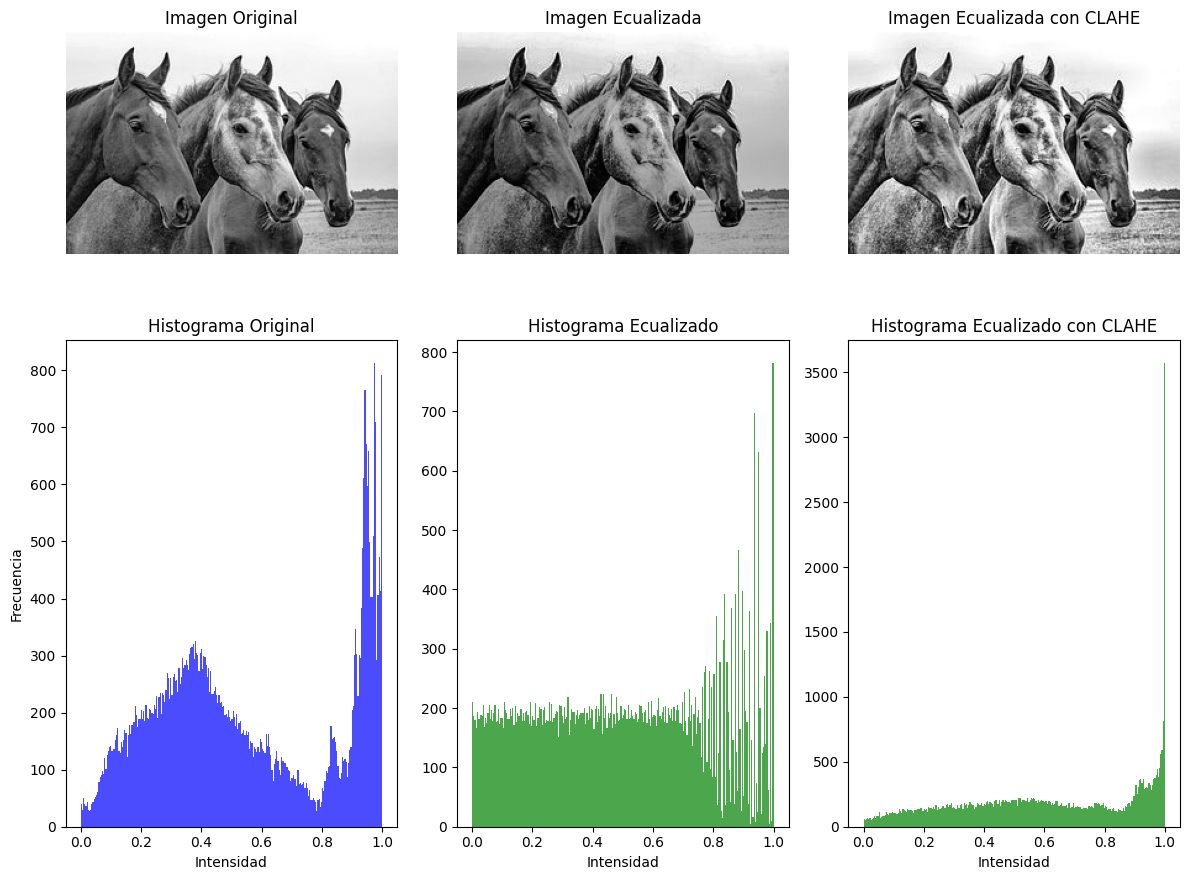

In [7]:
image_equalized_clahe = exposure.equalize_adapthist(image_gray)

# --- Visualización Comparativa ---
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Imagen Original y su Histograma
axes[0, 0].set_title('Imagen Original')
axes[0, 0].imshow(image_gray, cmap='gray')
axes[0, 0].axis('off')

axes[1, 0].set_title('Histograma Original')
axes[1, 0].hist(image_gray.ravel(), bins=256, color='blue', alpha=0.7)
axes[1, 0].set_xlabel('Intensidad')
axes[1, 0].set_ylabel('Frecuencia')

# Imagen Ecualizada y su Histograma
axes[0, 1].set_title('Imagen Ecualizada')
axes[0, 1].imshow(image_equalized_sk, cmap='gray')
axes[0, 1].axis('off')

axes[1, 1].set_title('Histograma Ecualizado')
axes[1, 1].hist(image_equalized_sk.ravel(), bins=256, color='green', alpha=0.7)
axes[1, 1].set_xlabel('Intensidad')

# Imagen Ecualizada y su Histograma
axes[0, 2].set_title('Imagen Ecualizada con CLAHE')
axes[0, 2].imshow(image_equalized_clahe, cmap='gray')
axes[0, 2].axis('off')

axes[1, 2].set_title('Histograma Ecualizado con CLAHE')
axes[1, 2].hist(image_equalized_clahe.ravel(), bins=256, color='green', alpha=0.7)
axes[1, 2].set_xlabel('Intensidad')

plt.tight_layout()
plt.show()

Vemos como la imagen ecualizada CLAHE resalta mucho más las diferencias entre los objetos, como los caballos en la imagen de ejemplo, al ir haciendo ecualizaciones locales. La diferencia en magnitud del blanco, siendo casi 4 veces más, también se debe a esto, con el cielo ecualizándose consigo mismo

**Ejercicio 2: Clasificador de Texturas Simple**
1.  Descarga dos imágenes de texturas muy diferentes (ej. tela vaquera y corteza de árbol).
2.  Calcula las 4 características de Haralick para ambas.
3.  Escribe una conclusión sobre qué característica(s) crees que sería(n) más útil(es) para distinguir estas dos texturas y por qué, basándote en los valores obtenidos.

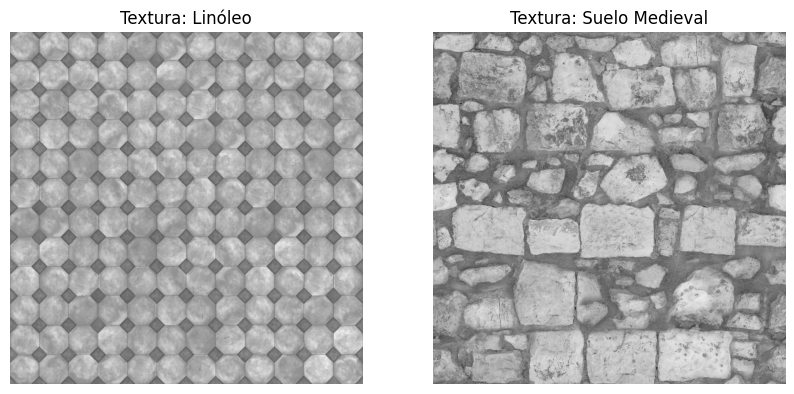

--- Características de Haralick para: Linóleo ---
  Contraste:   31.32
  Correlación: 0.95
  Energía:     0.03
  Homogeneidad:0.24

--- Características de Haralick para: Suelo Medieval ---
  Contraste:   120.46
  Correlación: 0.94
  Energía:     0.02
  Homogeneidad:0.18



In [8]:
# Cargar imágenes con texturas diferentes

img_linoleum = cv2.imread("linoleum_flooring.jpg")
image_linoleum_gray = cv2.cvtColor(img_linoleum, cv2.COLOR_BGR2GRAY)
img_blocks = cv2.imread("medieval_blocks.jpg")
image_blocks_gray = cv2.cvtColor(img_blocks, cv2.COLOR_BGR2GRAY)

# Función para calcular y mostrar las características
def compute_and_print_haralick(image, name):
    # Calcular GLCM. Usaremos una distancia de 1 píxel en 4 direcciones (0, 45, 90, 135 grados)
    glcm = graycomatrix(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    # Calcular las características promediando sobre los ángulos
    contrast = np.mean(graycoprops(glcm, 'contrast'))
    correlation = np.mean(graycoprops(glcm, 'correlation'))
    energy = np.mean(graycoprops(glcm, 'energy'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))

    print(f"--- Características de Haralick para: {name} ---")
    print(f"  Contraste:   {contrast:.2f}")
    print(f"  Correlación: {correlation:.2f}")
    print(f"  Energía:     {energy:.2f}")
    print(f"  Homogeneidad:{homogeneity:.2f}\n")

# --- Visualización y Cálculo ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_linoleum_gray, cmap='gray')
axes[0].set_title('Textura: Linóleo')
axes[0].axis('off')

axes[1].imshow(image_blocks_gray, cmap='gray')
axes[1].set_title('Textura: Suelo Medieval')
axes[1].axis('off')
plt.show()

compute_and_print_haralick(image_linoleum_gray, "Linóleo")
compute_and_print_haralick(image_blocks_gray, "Suelo Medieval")

Vemos que las 2 características en las que más difieren ambas superficies es el contraste, con el linóleo siendo un cuarto del contraste del suelo medieval, y la homgeneidad. Esto es similar al caso de ejemplo, con el linóleo siendo una textura mucho más repetitiva y estructurada que el suelo medieval.

**Ejercicio 3: Segmentación y Conteo de Objetos**
1.  Usa el resultado `cleaned_image` de la sección de Otsu.
2.  Investiga la función `skimage.measure.label` para etiquetar cada región conectada (cada moneda) con un número diferente.
3.  El número de etiquetas encontradas corresponde al número de objetos. Imprime en pantalla: "Se han encontrado [N] monedas".
4.  Muestra la imagen etiquetada usando `plt.imshow(labeled_image, cmap='nipy_spectral')`.

Se han encontrado 41 monedas


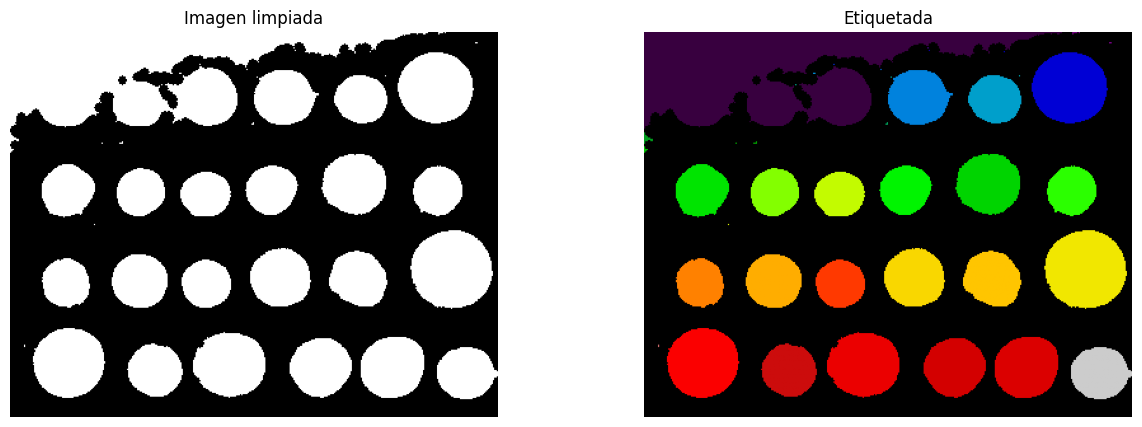

In [9]:
labeled_image = measure.label(cleaned_image)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Imagen limpiada')
plt.imshow(cleaned_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Etiquetada')
plt.imshow(labeled_image, cmap='nipy_spectral')
plt.axis('off')

print(f"Se han encontrado {labeled_image.max()} monedas")

# TODO: ¿cambiar conectividad? Justificar

**Ejercicio 4: Robustez del Template Matching**
1.  Toma la plantilla original (`template.jpg`).
2.  Modifícala ligeramente: rótala unos pocos grados o cambia su escala (hazla un poco más pequeña o grande).
3.  Vuelve a ejecutar el algoritmo de template matching con esta nueva plantilla. ¿Sigue funcionando bien? ¿Qué valor máximo de correlación obtienes ahora?
4.  Escribe una breve conclusión sobre la sensibilidad del template matching a la rotación y la escala.

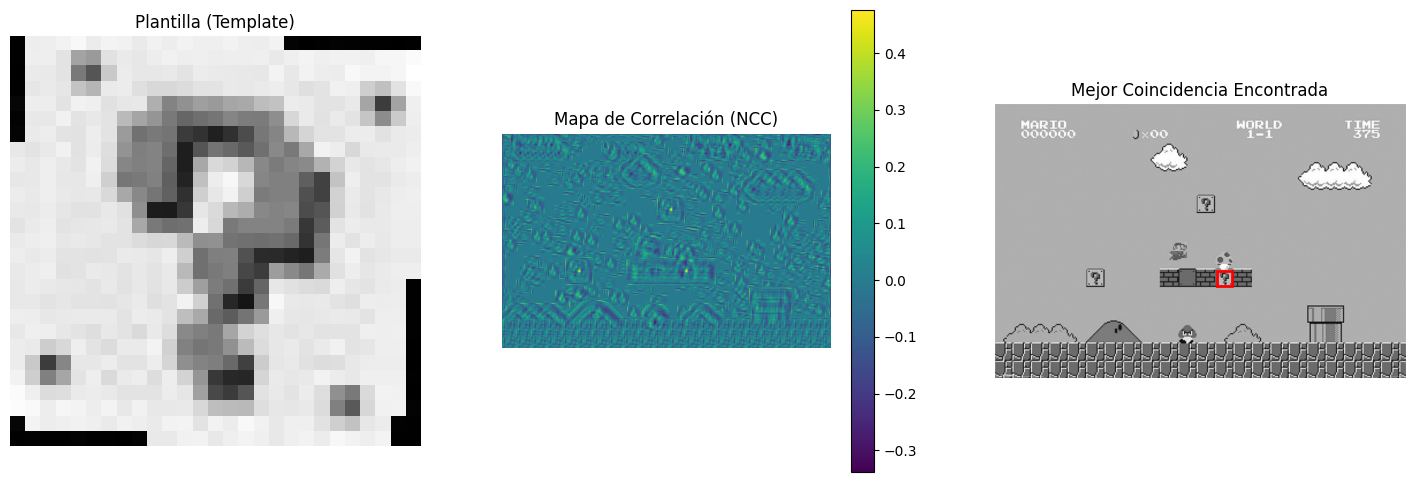

In [10]:
template = cv2.imread("template_modified.jpg")
template_gray = util.img_as_ubyte(cv2.cvtColor(template, cv2.COLOR_BGR2GRAY))

result = cv2.matchTemplate(image_main_gray, template_gray, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

top_left = max_loc
h, w = template_gray.shape
bottom_right = (top_left[0] + w, top_left[1] + h)

# --- Visualización ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(template_gray, cmap='gray')
axes[0].set_title('Plantilla (Template)')
axes[0].axis('off')

# Mostrar el mapa de correlación
im = axes[1].imshow(result, cmap='viridis')
axes[1].set_title('Mapa de Correlación (NCC)')
axes[1].axis('off')
fig.colorbar(im, ax=axes[1])

# Dibujar el rectángulo en la imagen principal
axes[2].imshow(image_main_gray, cmap='gray')
axes[2].add_patch(plt.Rectangle(top_left, w, h, edgecolor='red', facecolor='none', linewidth=2))
axes[2].set_title('Mejor Coincidencia Encontrada')
axes[2].axis('off')

plt.show()

Aunque la primera impresión pueda ser que la modificación no haya afectado tanto, si nos fijamos en la escala del mapa de correlación vemos que los valores se han dividido prácticamente a la mitad, con el modelo teniendo mayor problema en encontrar el patrón en la imagen.

Aun así, sigue encontrando coincidencias coherentes, con las mejores coincidencias siendo correctas.